In [58]:
## Ambient Fisher Gnomonic Interpolant

by Kyle Cranmer, Jan 12, 2014, BSD license

based on notes and discussion with Jeff Streets at UCI.

<img src="files/gnome-fishing.jpg" alt="Gnome Fisher" width="20%"><img src="files/gnome-mesh.jpg" alt="Gnome Mesh" width="20%">
<!--
![Gnome Fisher](files/gnome-fishing.jpg)![gnome mesh](files/gnome-mesh.jpg)
-->

In [59]:
%matplotlib inline

In [60]:
import numpy as np
import numpy.linalg as linalg
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn import manifold
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import minimize
import scipy.optimize
from math import sqrt
from scipy.spatial import Delaunay

## Create pairs of (parameter, distribution)

In [61]:
#parameter points
alphas = np.array([[0,0],[1,0],[0,1]])

# dim = 1+#dim parameters = dim of embedding
dim = 3 
# for starters, define a parametrized family of functions explicitly and draw from it
f = lambda alpha: lambda x : np.exp(-0.5*(x-alpha[0])**2 / (0.5*alpha[1]+1)**2)/np.sqrt(2*np.pi) / (0.5*alpha[1]+1)
dists = []
for alpha in alphas:
    dists.append( f(alpha) )

## Calculate pair-wise chord distances, embed on n-sphere, & rotate first to south pole

It's going to be easier to work in the space of the sqrt of distributions, so let's define a simple transformation q 

In [62]:
q = lambda h: (lambda x: np.sqrt(h(x)))

In [63]:
def inner_product(q1,q2, xmin=-7, xmax=7):
    # this is a simple numeric integration
    num = 10000.
    xarray = np.linspace(xmin,xmax,num)
    return np.sum(q1(xarray) * q2(xarray))*(xmax-xmin)/num

In [64]:
(inner_product(q(dists[0]),q(dists[0])), inner_product(q(dists[1]),q(dists[1])),inner_product(q(dists[2]),q(dists[2])))

(0.99989999999745338, 0.99989999901776028, 0.99989694599725443)

## Create pairs of (parameter simplex, Gnomonic simplex)

In [65]:
def getChordDistance(q1,q2):
    return 2.*np.sin( np.arccos( inner_product(q1, q2) ) /2. )

In [66]:
tempSim=[]
for f1 in dists:
    temp = []
    for f2 in dists:
        temp.append(getChordDistance(q(f1),q(f2)))
    tempSim.append(temp)
chordDistMatrix=np.array(tempSim)
chordDistMatrix #diagonals should be close to 0

array([[ 0.01414214,  0.48495638,  0.28045376],
       [ 0.48495638,  0.01414221,  0.4700093 ],
       [ 0.28045376,  0.4700093 ,  0.01435646]])

In [67]:
## Embeding functions onto n-sphere
n=dim-1
embeded=np.zeros(shape=(dim,dim))
embeded[0]=[0,0,-1]
a=np.array([[-1], [2,3]], dtype=object)

for k in range(1,dim):
    y=np.empty([k,k])
    z=np.zeros(k)
    for j in range(0,k):
        z[j]=1-(chordDistMatrix[j][k]**2)*0.5
        y[j]=np.delete(embeded[j],np.arange(n+1-k))
    x = np.linalg.solve(y,z)
    x_0k=-sqrt(1-np.sum(x**2)) #negative sign to keep it totally in southern hemisphere
    a=np.append(x_0k,x)
    embeded[k]=np.append(np.zeros(n-k),a)
embeded

array([[ 0.        ,  0.        , -1.        ],
       [ 0.        , -0.47048376, -0.88240865],
       [-0.26305768, -0.08892889, -0.96067284]])

In [68]:
pointsOnSphere = embeded.copy()

In [69]:
gnomonicProjection = pointsOnSphere.copy()
for i, point in enumerate(pointsOnSphere):
    gnomonicProjection[i] = -1.*point/point[-1]

In [70]:
nSamples = 15 #samples along ray for visualization
rays = np.zeros((3*nSamples,dim))
for i, point in enumerate(gnomonicProjection):
    for j, c in enumerate(np.linspace(0,1,nSamples)):
        rays[i*nSamples+j] = c * point

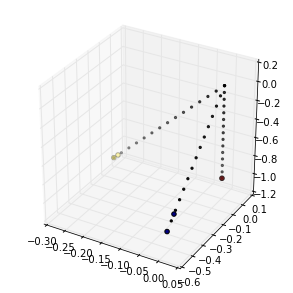

In [71]:
fig = plt.figure(figsize=(5,5))
subpl = fig.add_subplot(111,projection='3d')
subpl.scatter(rays[:, 0], rays[:, 1], rays[:, 2],marker='.',c=pointsOnSphere[:,0]*0+.01)
subpl.scatter(pointsOnSphere[:, 0], pointsOnSphere[:, 1],pointsOnSphere[:, 2],
              marker='o',c=-pointsOnSphere[:,2])#,cmap=mpl.cm.gray)
subpl.scatter(gnomonicProjection[:, 0], gnomonicProjection[:, 1], gnomonicProjection[:, 2],
              c=-pointsOnSphere[:,2])#,cmap=mpl.cm.gray)
plt.show()

In [72]:
alphaSimplex = Delaunay(alphas)
gnomonicSimplex = Delaunay(gnomonicProjection[:3,:2])

In [73]:
normedVertices = gnomonicProjection[:3,:2].copy()
normedVertices[1] /= linalg.norm(normedVertices[1])
normedVertices[2] /= linalg.norm(normedVertices[2])
normedSimplex = Delaunay(normedVertices)

In [74]:
inner_product(q(dists[0]),q(dists[1])),inner_product(q(dists[0]),q(dists[2])),inner_product(q(dists[1]),q(dists[2]))

(0.88240865285903869, 0.96067284335362202, 0.88954562783004798)

In [75]:
pointsOnSphere[0].dot(pointsOnSphere[1]),pointsOnSphere[0].dot(pointsOnSphere[2]),pointsOnSphere[1].dot(pointsOnSphere[2])

(0.88240865285903869, 0.96067284335362202, 0.88954562783004798)

## Create Interpolant

In [76]:
alpha1 = np.array([0.9,0.0]) #for testing
alpha2 = np.array([0.0,.9]) #for testing
alpha = alpha2 #switch for testing
alpha = np.array([0.5,0.3])
baryCoords = alphaSimplex.transform[0,:dim-1,:].dot(alpha)
gnomonicTarget = linalg.inv(gnomonicSimplex.transform[0,:dim-1,:]).dot(baryCoords)
normedBaryCoords = normedSimplex.transform[0,:dim-1,:].dot(gnomonicTarget)
t = np.arctan(linalg.norm(gnomonicTarget))
t, normedBaryCoords, linalg.norm(gnomonicTarget), linalg.norm(gnomonicProjection[1,:2]), linalg.norm(gnomonicProjection[2,:2])
gnomonicProjection[1:], gnomonicTarget

(array([[ 0.        , -0.53318126, -1.        ],
        [-0.27382649, -0.09256938, -1.        ]]),
 array([ 0.21906119, -0.08589888]))

In [77]:
dot01 = inner_product(q(dists[0]),q(dists[1]))
dot02 = inner_product(q(dists[0]),q(dists[2]))
t1 = lambda x: q(dists[1])(x) - dot01*q(dists[0])(x)
t2 = lambda x: q(dists[2])(x) - dot02*q(dists[0])(x)
norm1 = inner_product(t1,t1)
norm2 = inner_product(t2,t2)
u1 = lambda x: t1(x)/np.sqrt(norm1)
u2 = lambda x: t2(x)/np.sqrt(norm2)
#unnorm_tan = lambda x: u1(x)*normedBaryCoords[1] + u2(x)*normedBaryCoords[0]
unnorm_tan = lambda x: u1(x)*normedBaryCoords[0]+u2(x)*normedBaryCoords[1]
norm_tan = inner_product(unnorm_tan,unnorm_tan)
tangent = lambda x: unnorm_tan(x) / np.sqrt(norm_tan)
#tangent = lambda x: (u1(x)*normedBaryCoords[1] + u2(x)*normedBaryCoords[0])/np.sqrt(norm_tan)
#tangent = lambda x: (u1(x)*normedBaryCoords[0] + u2(x)*normedBaryCoords[1])/np.sqrt(norm_tan)
print inner_product(q(dists[0]),tangent), inner_product(tangent,tangent)
q_interpolant = lambda x: np.cos(t)*q(dists[0])(x) + np.sin(t)*tangent(x) 
interpolant = lambda x: ( np.cos(t)*q(dists[0])(x) + np.sin(t)*tangent(x) )**2
#interpolant = lambda x: (q_interpolant(x)*q_interpolant(x))
#interpolant = lambda x: ( np.cos(t)*q(dists[0])(x) + np.sin(t)*u1(x) )**2
np.arccos(inner_product(q(interpolant),q(dists[0]))),inner_product(q(interpolant),q(interpolant))

0.000280751884478 1.0


(0.23124110486386215, 1.000030437042255)

In [78]:
np.arccos(dot02), t, np.arccos(dot01)

(0.28138111338199129, 0.23109691282279765, 0.48983892578549054)

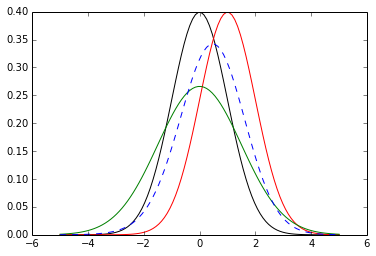

In [79]:
xarray = np.linspace(-5,5,100)
plt.plot(xarray,dists[0](xarray),c='black')
plt.plot(xarray,dists[1](xarray),c='r')
plt.plot(xarray,dists[2](xarray),c='g')
plt.plot(xarray,interpolant(xarray),c='b',ls='dashed')

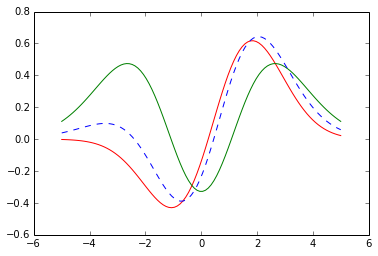

In [80]:
plt.plot(xarray,u1(xarray),c='r')
plt.plot(xarray,u2(xarray),c='g')
#plt.plot(xarray,unnorm_tan(xarray),c='black')
plt.plot(xarray,tangent(xarray),c='b',ls='dashed')

## check if original points + interpolant work on embeded 2-sphere

In [81]:
targetOnSphere = gnomonicTarget3d/linalg.norm(gnomonicTarget3d)
targetOnSphere.dot(pointsOnSphere[0]), targetOnSphere.dot(pointsOnSphere[1]), targetOnSphere.dot(pointsOnSphere[2])

NameError: name 'gnomonicTarget3d' is not defined

In [220]:
inner_product( q(dists[0]),q(interpolant)), inner_product( q(dists[1]),q(interpolant)), inner_product( q(dists[2]),q(interpolant) )

(0.97338270117552661, 0.96004931887381895, 0.97512816672400293)

Visualize ray pointing to the target

In [221]:
targetRays = np.zeros(15*3).reshape(15,3)
gnomonicTarget3d = np.zeros(3)
gnomonicTarget3d[:2] = gnomonicTarget
gnomonicTarget3d[2]=-1
for i,l in enumerate(np.linspace(0,1,15)):
    targetRays[i] = l*gnomonicTarget3d